In [1]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.dpi'] = 150
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchmetrics
import lightning as L
import torchattacks
from torchattacks import VANILA, FGSM, PGD, JSMA
import tqdm

# from Definitions_TOY
from Definitions_TOY import T, DATA_PATH, MODELS_PATH, FIGURES_PATH, RANDOM_SEED
from Definitions_TOY import TEACHER_TO_STUDENTS
from Definitions_TOY import FullNetwork, ReducedNetwork
from Definitions_TOY import TeacherModel, StudentModel
from Definitions_TOY import parse_teacher_str, parse_student_str
from Definitions_TOY import recover_trained_weights
from Definitions_TOY import get_TOY_loaders
print(f"T = {T}")
print(f"RANDOM_SEED = {RANDOM_SEED}")

# seeding
L.seed_everything(RANDOM_SEED, workers=True)
torch.manual_seed(RANDOM_SEED)

# device info
device = torch.device("cpu")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
print(f"device = {device}")

Seed set to 42


T = 100
RANDOM_SEED = 42
device = mps


<font size=7><b>CPSC471 Project: Analysis (TOY)</b></font>

**Ruomu (Felix) Zou**

What do the decision boundaries of the models look like? How are the teachers/students of different sizes and trained at various temperatures different?

**Model naming conventions:**
* `{F,R}T_temp{1,T}`: The *{full (larger architecture), reduced (smaller architecture)}* teacher model trained with cross-entropy with softmax temperature *{$1$, $T$ ($T>1$)}*. NOTE: Soft labels are ALWAYS generated with temperatuer $T$ regardless of teacher training temperature.
* `{F,R}S_temp{1,T}_from_{F,R}T_temp{1,T}`: Given a *{full, reduced}* teacher model trained at temperature *{$1$, $T$}*, generate soft labels at temperature $T$ and train a *{full, reduced}* student model at temperature *{$1$, $T$}*.
* Examples:
    * `FS_tempT_from_FT_tempT` represents the student model of the DD paper.
    * `RS_tempT_from_FT_temp1` represents the student model of traditional (Hinton) knowledge distillation.
    * `{F,R}S_temp1_from_{F,R}T_temp1` represents distillation where the only application of temperature is during soft label generation.
    * `{F,R}S_temp1_from_{F,R}T_tempT` represents something unconventional and weird.

# Constants and configurations:

In [2]:
# inference-specific constants and configurations
BATCH_SIZE = 1200 # entire dataset is 1 batcc

# Helper Functions:

In [13]:
def plot_incorrect_datapoints_on_ax(ax, model_str, dataloader, legend=True, title_prefix=""):
    """Plot the incorrectly predicted datapoints for given model on given axis.

    Args:
        ax: axis to plot on.
        model_str: a string in either teacher or student format.
        dataloader: the dataloader to plot predictions for.
        legend: bool, whether to plot legend.
        title_prefix: The prefix to put on the axis title.
    Returns:
        None
    """
    # recover weights
    network = recover_trained_weights(model_str)

    # recover and inputs and labels
    dataset = dataloader.dataset
    X, y_true = dataset.x, dataset.y

    # get the predictions and compute accuracy
    y_pred = network(X).argmax(-1).numpy()
    accuracy = (y_true==y_pred).mean()

    # plot
    correct_mask = y_true==y_pred
    incorrect_mask = y_true!=y_pred
    ax.scatter(X[correct_mask,0], X[correct_mask,1], c="tab:green", label="Correct")
    ax.scatter(X[incorrect_mask,0], X[incorrect_mask,1], c="tab:red", label="Incorrect")
    ax.set_title(f"{title_prefix}{model_str} (accuracy {round(accuracy*100, 2)}%)",fontsize=10)
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    if legend:
        ax.legend(loc="upper right")

def plot_decision_boundary_on_ax(ax, model_str, dataloader, overlay_datapoints=True, hard_boundaries=False,
                                 legend=True, granularity=500, title_prefix="", temp=T, divide_by_T=False):
    """Plot decision boundary (represented as heatmap-like overlay on input space) for given model on given axis.

    Args:
        ax: axis to plot on.
        model_str: a string in either teacher or student format.
        dataloader: the dataloader to plot boundaries for.
        overlay_datapoints: bool, whether to plot datapoints on top of heatmap.
        hard_boundaries: whether to plot hard decision boundaries rather than heatmap.
        legend: bool, whether to plot legend.
        granularity: granularity of heatmap.
        title_prefix: The prefix to put on the axis title.
        temp: int, get model of temp.
        divide_by_T: whether to divide logits in T as in CW.
    Returns:
        None
    """
    # recover weights
    network = recover_trained_weights(model_str, temp=temp)

    # recover and inputs and labels
    dataset = dataloader.dataset
    X, y_true = dataset.x, dataset.y

    # create the meshgrid
    col_maxes = X.max(axis=0)[0].numpy() # torch max returns vals in [0] and indx in [1]
    col_mins = X.min(axis=0)[0].numpy()
    x0_space = np.linspace(start=col_mins[0], stop=col_maxes[0], num=granularity)
    x1_space = np.linspace(start=col_mins[1], stop=col_maxes[1], num=granularity)
    x0, x1 = np.meshgrid(x0_space, x1_space)
    x0 = x0.flatten()
    x1 = x1.flatten()
    X_grid = np.column_stack((x0,x1))
    X_grid = torch.Tensor(X_grid)

    # get predictions for each point in grid
    logits = network(X_grid).detach()
    if divide_by_T:
        logits = logits / temp
    probs = F.softmax(logits, dim=-1).numpy()
    if hard_boundaries:
        probs = (probs==probs.max(-1).reshape([-1,1])).astype(float)

    # reshape the probabilities into heatmap
    heatmap = probs.reshape((x1_space.shape[0], x0_space.shape[0], 3))
    heatmap = np.flip(heatmap, axis=0)

    # plot heatmap
    ax.imshow(heatmap, extent=[col_mins[0]-0.1, col_maxes[0]+0.1, col_mins[1]-0.1, col_maxes[1]+0.1])

    # optionall plot datapoints on top
    if overlay_datapoints:
        zeros_mask = y_true==0
        ones_mask = y_true==1
        twos_mask = y_true==2
        ax.scatter(X[zeros_mask,0], X[zeros_mask,1], c="tab:red", label="label = 0", s=10)
        ax.scatter(X[ones_mask,0], X[ones_mask,1], c="tab:green", label="label = 1", s=10)
        ax.scatter(X[twos_mask,0], X[twos_mask,1], c="tab:blue", label="label = 2", s=10)

    # plot config
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    if legend:
        ax.legend(loc="upper right")
    ax.set_title(f"{title_prefix}{model_str}",fontsize=10)
    return

# Execution:

## Get data:

In [4]:
trainloader = get_TOY_loaders(BATCH_SIZE)

## Mega plots (old code before changing `recover_trained_weights`, might not work as expected):

In [5]:
# # create subplots
# num_cols = 5
# num_rows = 4
# fig, ax = plt.subplots(4, 5, figsize=(4*num_cols,4*num_rows))

# # populate subplots
# for row, (teacher, students) in enumerate(TEACHER_TO_STUDENTS.items()):
#     # first plot teacher model
#     plot_decision_boundary_on_ax(ax[row][0], teacher, trainloader, legend=False)

#     # iterate through students and plot
#     for col, student in enumerate(students):
#         plot_decision_boundary_on_ax(ax[row][col+1], student, trainloader, legend=False)
    
# # superplot configurations
# fig.suptitle(f"Decision Heatmaps for All Teacher and Student Models (T={T})", fontsize=25, fontweight="bold")
# plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_PATH, f"DecisionHeatmaps_T{T}.png"))
# plt.show()

In [6]:
# # create subplots
# num_cols = 5
# num_rows = 4
# fig, ax = plt.subplots(4, 5, figsize=(4*num_cols,4*num_rows))

# # populate subplots
# for row, (teacher, students) in enumerate(TEACHER_TO_STUDENTS.items()):
#     # first plot teacher model
#     plot_decision_boundary_on_ax(ax[row][0], teacher, trainloader, hard_boundaries=True, legend=False)

#     # iterate through students and plot
#     for col, student in enumerate(students):
#         plot_decision_boundary_on_ax(ax[row][col+1], student, trainloader, hard_boundaries=True, legend=False)
    
# # superplot configurations
# fig.suptitle(f"Decision Boundaries for All Teacher and Student Models (T={T})", fontsize=25, fontweight="bold")
# plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_PATH, f"DecisionBoundaries_T{T}.png"))
# plt.show()

In [7]:
# # create subplots
# num_cols = 5
# num_rows = 4
# fig, ax = plt.subplots(4, 5, figsize=(3.5*num_cols,4*num_rows))

# # populate subplots
# for row, (teacher, students) in enumerate(TEACHER_TO_STUDENTS.items()):
#     # first plot teacher model
#     plot_incorrect_datapoints_on_ax(ax[row][0], teacher, trainloader, legend=False)

#     # iterate through students and plot
#     for col, student in enumerate(students):
#         plot_incorrect_datapoints_on_ax(ax[row][col+1], student, trainloader, legend=False)
    
# # superplot configurations
# fig.suptitle(f"Datapoints PredictedCorrectly (Green) and Incorrectly (Red) for All Teacher and Student Models (T={T})",
#              fontsize=25, fontweight="bold")
# plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_PATH, f"ClassificationAccuracies_T{T}.png"))
# plt.show()

## Single plots:

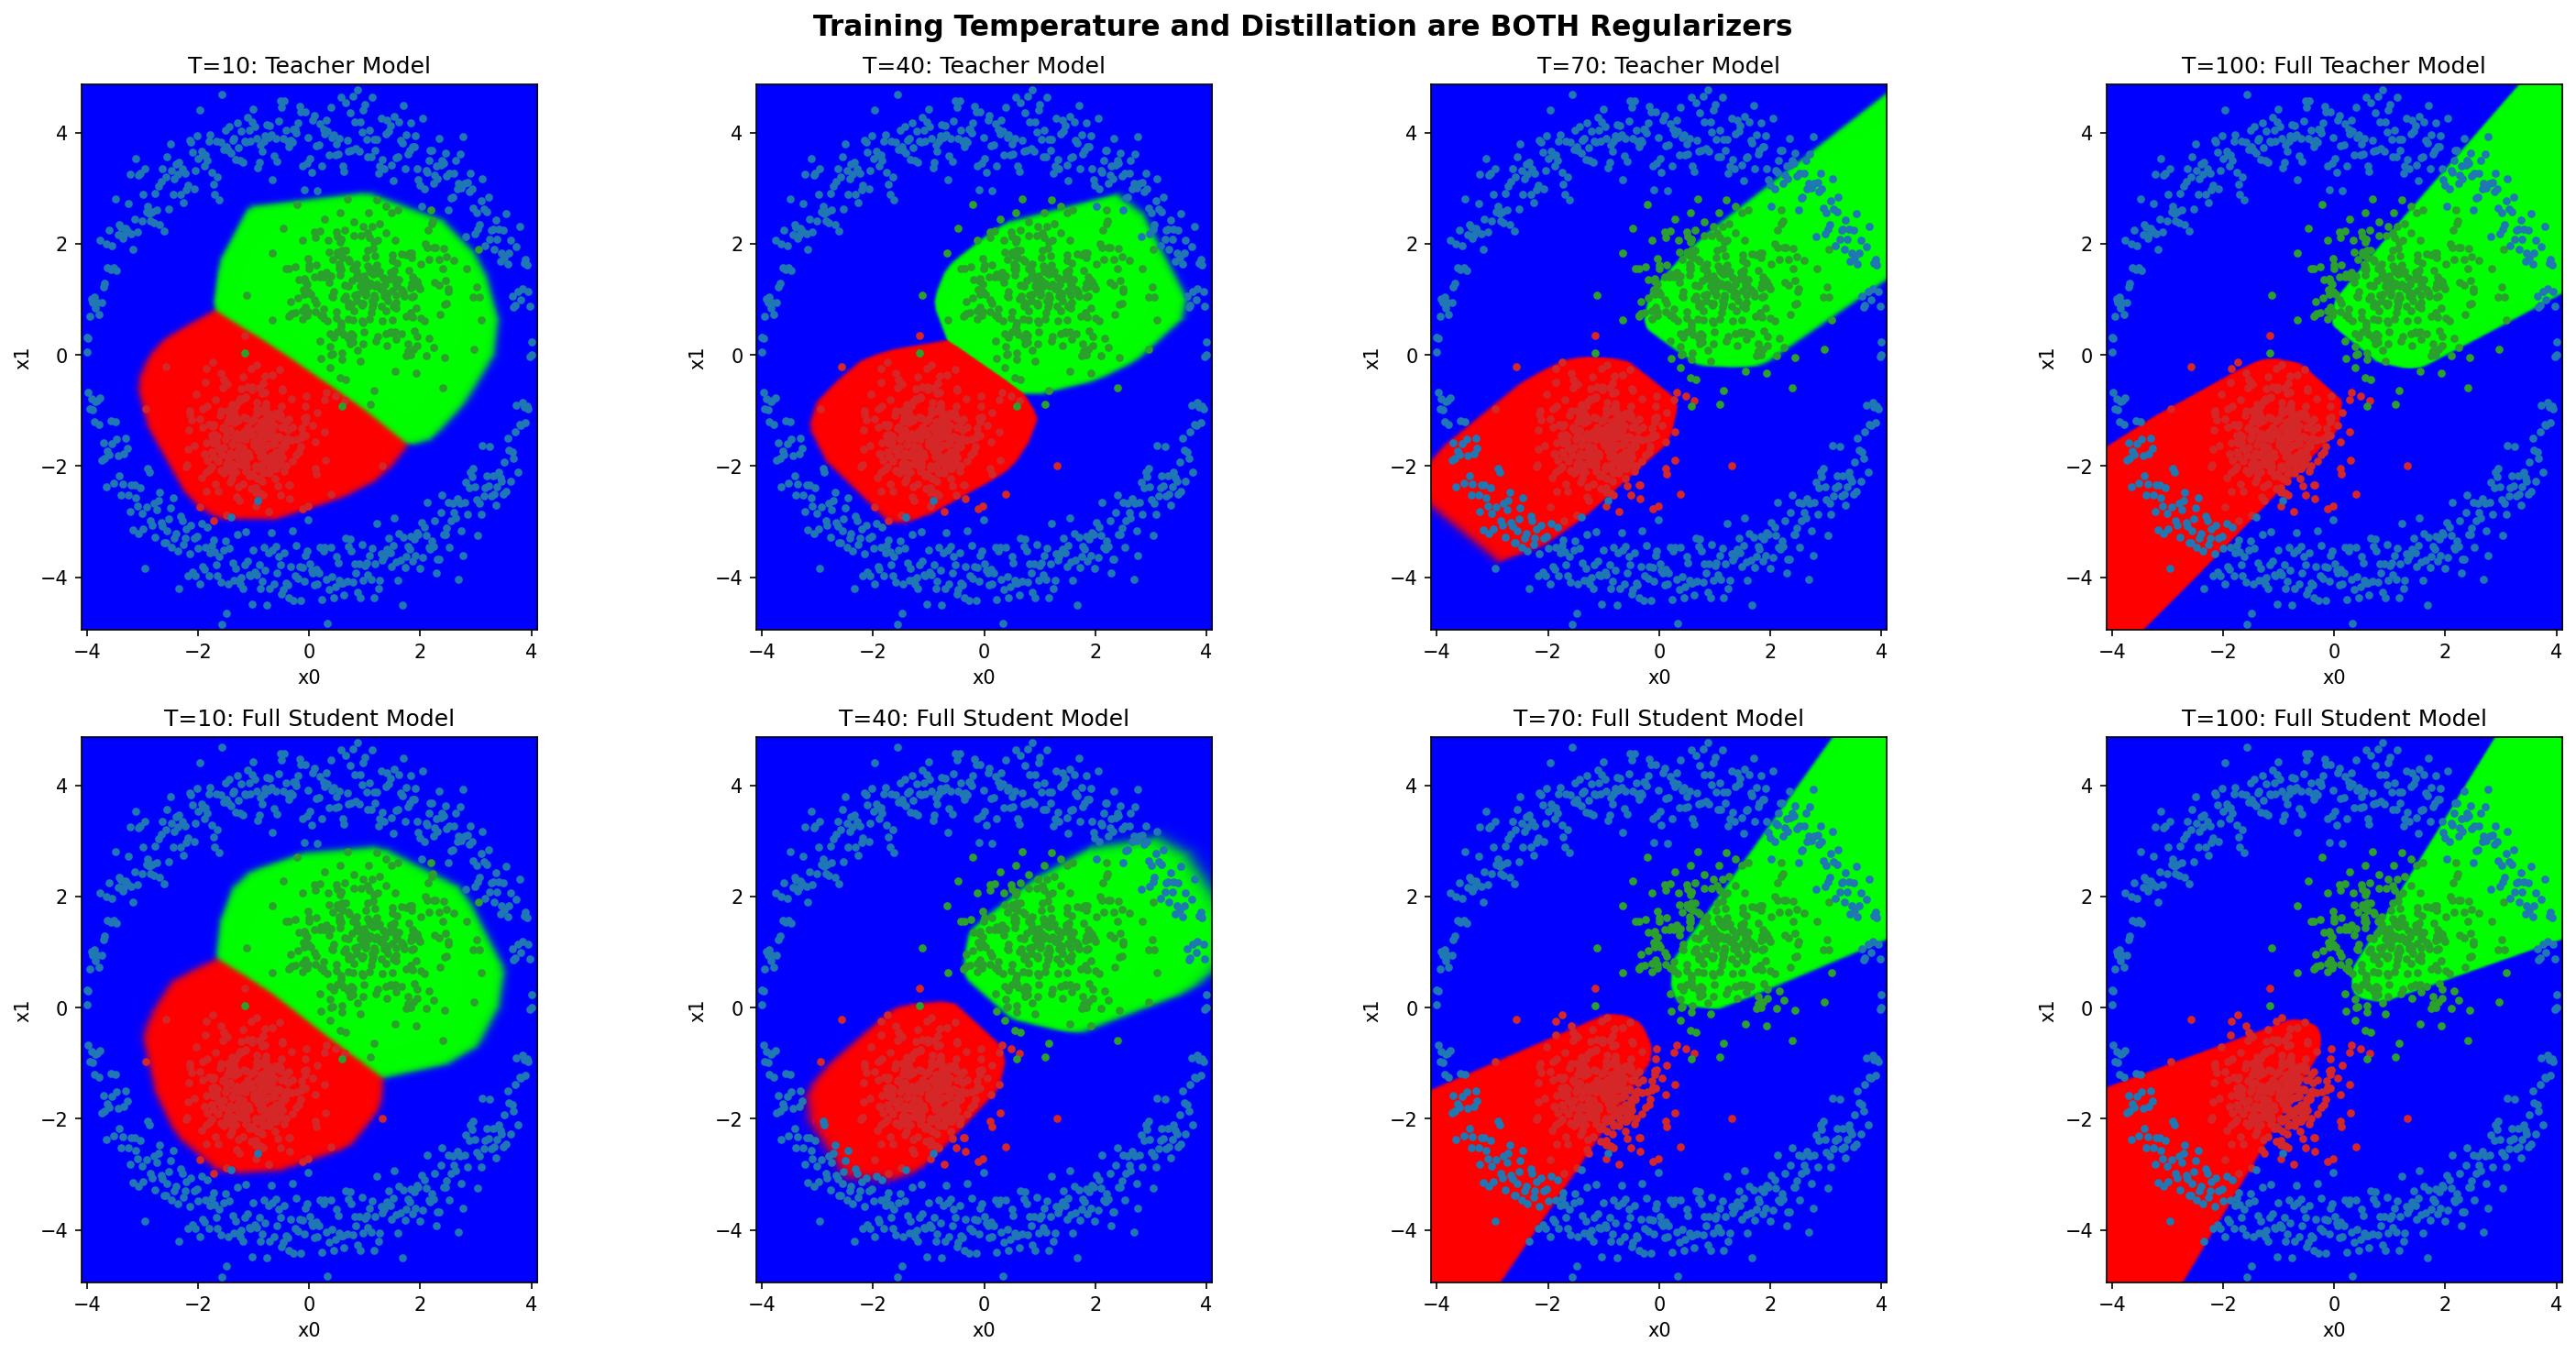

In [11]:
# subplots
fig, ax = plt.subplots(2,4,figsize=(20, 10))

# T = 10
plot_decision_boundary_on_ax(ax[0][0], "FT_tempT", trainloader, hard_boundaries=False,
                             legend=False, temp=10)
ax[0][0].set_title("T=10: Teacher Model")
plot_decision_boundary_on_ax(ax[1][0], "FS_tempT_from_FT_tempT", trainloader, hard_boundaries=False,
                             legend=False, temp=10)
ax[1][0].set_title("T=10: Full Student Model")

# T = 40
plot_decision_boundary_on_ax(ax[0][1], "FT_tempT", trainloader, hard_boundaries=False,
                             legend=False, temp=40)
ax[0][1].set_title("T=40: Teacher Model")
plot_decision_boundary_on_ax(ax[1][1], "FS_tempT_from_FT_tempT", trainloader, hard_boundaries=False,
                             legend=False, temp=40)
ax[1][1].set_title("T=40: Full Student Model")

# T = 70
plot_decision_boundary_on_ax(ax[0][2], "FT_tempT", trainloader, hard_boundaries=False,
                             legend=False, temp=70)
ax[0][2].set_title("T=70: Teacher Model")
plot_decision_boundary_on_ax(ax[1][2], "FS_tempT_from_FT_tempT", trainloader, hard_boundaries=False,
                             legend=False, temp=70)
ax[1][2].set_title("T=70: Full Student Model")

# T = 100
plot_decision_boundary_on_ax(ax[0][3], "FT_tempT", trainloader, hard_boundaries=False,
                             legend=False, temp=100)
ax[0][3].set_title("T=100: Full Teacher Model")
plot_decision_boundary_on_ax(ax[1][3], "FS_tempT_from_FT_tempT", trainloader, hard_boundaries=False,
                             legend=False, temp=100)
ax[1][3].set_title("T=100: Full Student Model")

# superplot
fig.suptitle("Training Temperature and Distillation are BOTH Regularizers",
             fontsize=15, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, f"BothRegularizers.png"))
plt.show()

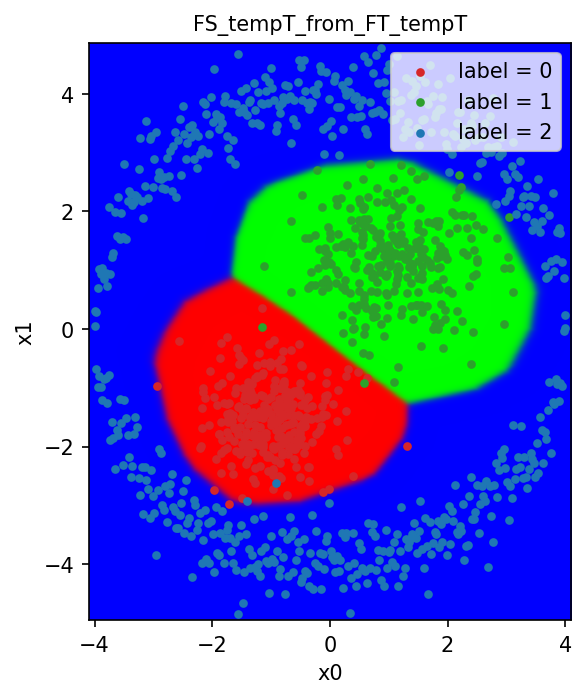

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_decision_boundary_on_ax(ax, "FS_tempT_from_FT_tempT", trainloader, temp=10, divide_by_T=False)
plt.show()